<a href="https://colab.research.google.com/github/HelenLit/sign-language_CNN/blob/main/sign-lang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Downloading the training and test sets (the test set will actually be used as a validation set):

In [4]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 141MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 128MB/s]


Defining some globals with the path to both files you just downloaded:

In [5]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

Taking a look at how the data looks like within the csv file:

In [6]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

Each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values.

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image.
The original images have a resolution of 28x28, which sums up to 784 pixels.

 ## Parsing the dataset

 **`parse_data_from_input`**

 This function to reads a file passed as input and returns 2 numpy arrays, one containing the labels and one containing the 28x28 representation of each image within the file. These numpy arrays have type `float64`.

In [7]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file

  Args:
    filename (string): path to the CSV file

  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    csv_reader = csv.reader(file, delimiter=',')
    next(csv_reader)
    images = []
    labels = []

    for row in csv_reader:
        images.append([int(num) for num in row[1:]])
        labels.append(int(row[0]))

    labels = np.array(labels, dtype=np.float64)
    images = np.array(images, dtype=np.float64).reshape((-1, 28, 28))

    return images, labels

In [8]:
# Testing function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays

Now that I have converted the initial csv data into a format that is compatible with computer vision tasks, lets take a moment to actually see how the images of the dataset look like:

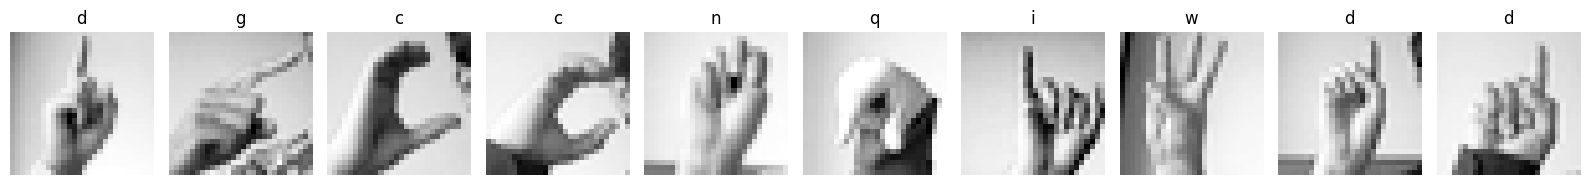

In [9]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

Now that I have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time to code the generators that will yield batches of images, both for training and validation. For this completed the `train_val_generators` function below.

I should add the "color" dimension to the numpy arrays that encode the images. These are black and white images, so this new dimension should have a size of 1 (instead of 3, which is used when dealing with colored images).

In [10]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  training_images = np.expand_dims(training_images, axis=-1)
  validation_images = np.expand_dims(validation_images, axis=-1)

  train_datagen = ImageDataGenerator(rescale=1./255.,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)

  validation_datagen = ImageDataGenerator(rescale=1./255.)

  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32)

  return train_generator, validation_generator

In [11]:
# Testing generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN

One last step before training is to define the architecture of the model that will be trained.

`create_model` function below returns a Keras' model that uses the `Sequential` API.

The last layer of this model have a number of units that corresponds to the number of possible categories, as well as the correct activation function.

In [18]:
def create_model():

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(26, activation='softmax')])

  model.compile(optimizer = 'rmsprop',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

Defining the callback:

In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [20]:
# Saving model
model = create_model()

# Training model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=myCallback())

Epoch 1/20
858/858 [==============================] - 69s 79ms/step - loss: 2.7797 - accuracy: 0.1586 - val_loss: 1.7154 - val_accuracy: 0.4490
Epoch 2/20
858/858 [==============================] - 69s 81ms/step - loss: 1.9227 - accuracy: 0.3893 - val_loss: 0.8613 - val_accuracy: 0.7425
Epoch 3/20
858/858 [==============================] - 67s 78ms/step - loss: 1.4212 - accuracy: 0.5385 - val_loss: 0.6642 - val_accuracy: 0.7718
Epoch 4/20
858/858 [==============================] - 69s 80ms/step - loss: 1.1205 - accuracy: 0.6315 - val_loss: 0.4882 - val_accuracy: 0.8236
Epoch 5/20
858/858 [==============================] - 67s 78ms/step - loss: 0.9376 - accuracy: 0.6885 - val_loss: 0.4038 - val_accuracy: 0.8649
Epoch 6/20
858/858 [==============================] - 67s 78ms/step - loss: 0.7979 - accuracy: 0.7332 - val_loss: 0.3541 - val_accuracy: 0.8561
Epoch 7/20
858/858 [==============================] - 68s 79ms/step - loss: 0.7121 - accuracy: 0.7641 - val_loss: 0.2426 - val_accuracy:

Training history:

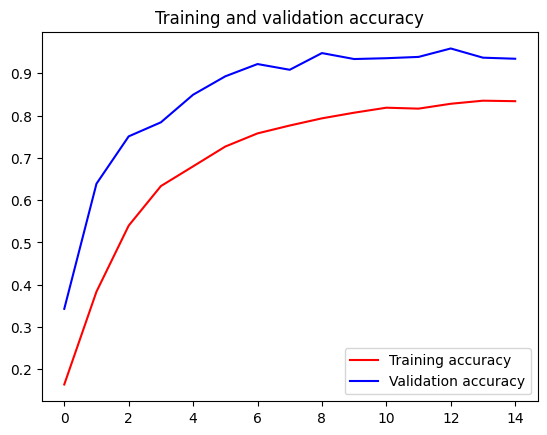

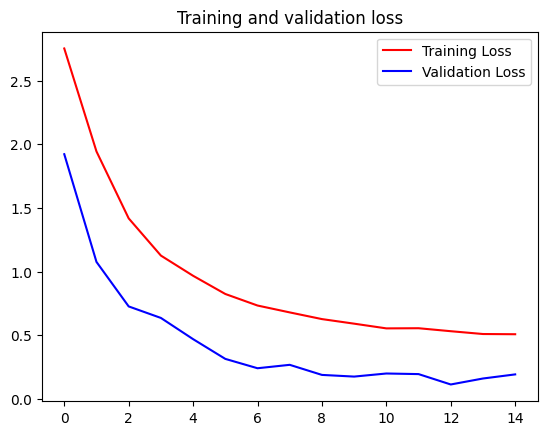

In [17]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()